In [1]:
import sys
sys.path.append('../')

import thermonets as tn
import numpy as np
import heyoka as hy
import pykep as pk
from nrlmsise00 import msise_flat
import spaceweather
from datetime import datetime
import pygmo as pg

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

We call the nrlmsise-00 model to establish a ground truth.

In [2]:
altitudes = np.logspace(2.2,2.8,50)
lats =  np.linspace(-150., 150., 10) 
lon = 60
f107A = 150.
f107 = 150.
ap = 4.
rho = msise_flat(datetime(2009, 6, 21, 8, 3, 20), altitudes[None,:], lats[:,None], lon, f107A, f107, ap)[:,:,5]

Text(0, 0.5, 'Density [g/cm^3]')

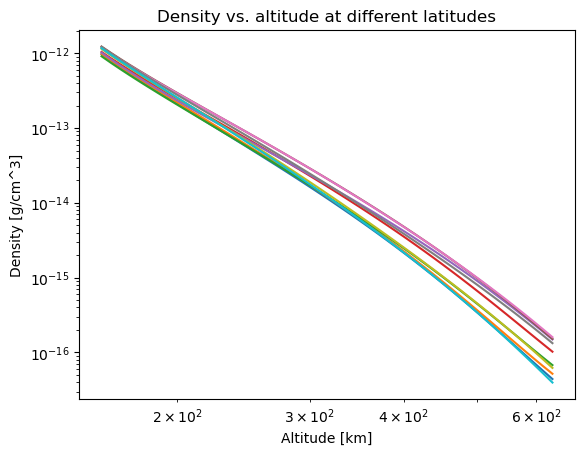

In [3]:
plt.loglog(altitudes, rho.T)
plt.title("Density vs. altitude at different latitudes")
plt.xlabel("Altitude [km]")
plt.ylabel("Density [g/cm^3]")


Lets fit the data with our formula.

In [4]:
target = 7
udp = tn.global_fit_udp(altitudes, rho[target,:], n=4)
prob = pg.problem(udp)

In [5]:
uda = pg.sade(50, memory=True, )
algo = pg.algorithm(uda)
pop  =pg.population(prob, 30)

In [6]:
for i in range(500):
    pop = algo.evolve(pop)
print("We achieved: ", pop.champion_f)

We achieved:  [0.00060826]


Text(0, 0.5, 'Density [g/cm^3]')

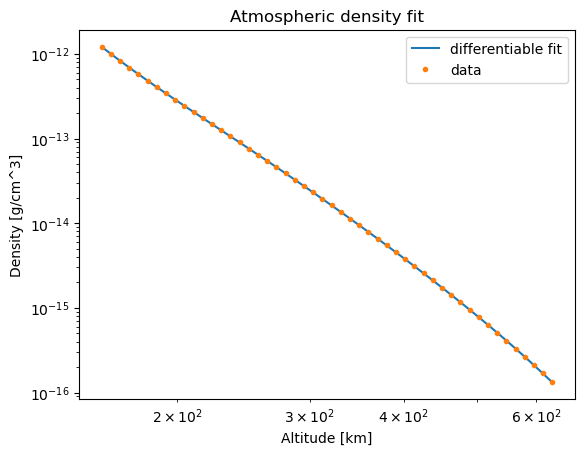

In [7]:
plt.figure()
plt.loglog(altitudes, tn.rho_approximation(altitudes, pop.champion_x), label ='differentiable fit')
plt.loglog(altitudes, rho[target,:], '.', label='data')
plt.legend()
plt.title("Atmospheric density fit")
plt.xlabel("Altitude [km]")
plt.ylabel("Density [g/cm^3]")

We repeat for all different lats.

In [9]:
best_x = []
best_f = []
for target in range(10):
    udp = tn.global_fit_udp(altitudes, rho[target, :], n=4)
    prob = pg.problem(udp)
    uda = pg.sade(50, memory=True)
    algo = pg.algorithm(uda)
    pop = pg.population(prob, 30)
    for i in range(500):
        pop = algo.evolve(pop)
    print("For sample  ", target, " We achieved: ", pop.champion_f, flush=True)
    best_x.append(pop.champion_x)
    best_f.append(pop.champion_f)

For 0  We achieved:  [0.00269302]
For 1  We achieved:  [0.00122365]
For 2  We achieved:  [0.00115264]
For 3  We achieved:  [0.00248435]
For 4  We achieved:  [0.00135231]
For 5  We achieved:  [0.00119328]
For 6  We achieved:  [0.00045706]
For 7  We achieved:  [0.00044845]
For 8  We achieved:  [0.00063091]
For 9  We achieved:  [0.00128424]


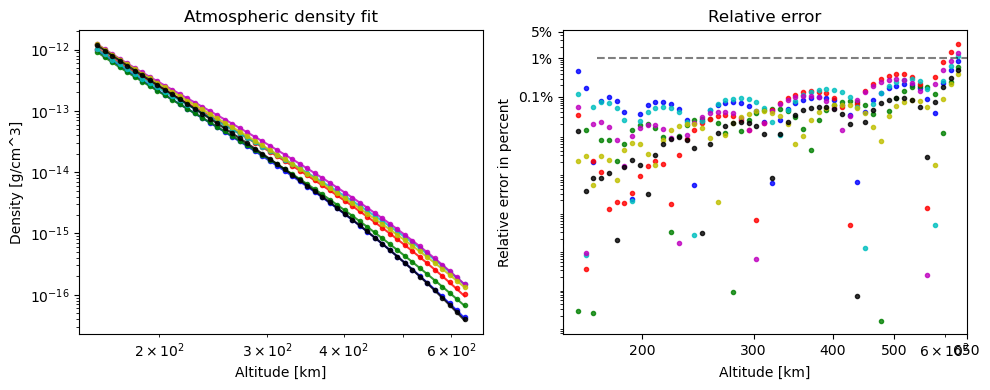

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
colors = ["b", "g", "r", "c", "m", "y","k"]

for j, i in enumerate([0, 2, 3,4, 5, 7, 9]):
    ax[0].loglog(altitudes, tn.rho_approximation(altitudes, best_x[i]), c=colors[j], alpha=0.8)
    ax[0].loglog(altitudes, rho[i, :], ".", c=colors[j], alpha=0.8)
ax[0].set_title("Atmospheric density fit")
ax[0].set_xlabel("Altitude [km]")
ax[0].set_ylabel("Density [g/cm^3]")

for j, i in enumerate([0, 2, 3,4, 5, 7, 9]):
    rel_err = (tn.rho_approximation(altitudes, best_x[i]) - rho[i, :]) / np.linalg.norm(
        rho[:, :], axis=0
    )
    ax[1].loglog(altitudes, 100 * np.abs(rel_err), '.', c=colors[j], alpha=0.8)
ax[1].set_title("Relative error")
ax[1].set_xlabel("Altitude [km]")
ax[1].set_ylabel("Relative error in percent")

ax[1].set_xlim([150,650])
ax[1].vlines(150, 1e-8, 10, 'k', linestyle='--', alpha=0.5)
ax[1].hlines(1, 170, 1500, 'k', linestyle='--', alpha=0.5)

ax[1].set_yticks([5, 1, 0.1], ["5%", "1%", "0.1%"])
ax[1].set_xticks([200, 300, 400,500, 650], ["200", "300", "400", "500", "650"])

plt.tight_layout()
plt.savefig("rho_error", dpi=600)

All in all we conclude that the analytical formula is capable to capture well the density trend with the altitude, fixing all other values.